# Data curation for the LTKB dataset

Author: Tim Dudgeon (tdudgeon@informaticsmatters.com)

This notebook illustrates approaches to preparing a dataset for use in generating predictive models.
It uses the [LTKB dataset from the FDA](https://www.fda.gov/ScienceResearch/BioinformaticsTools/LiverToxicityKnowledgeBase/ucm2024036.htm).

This dataset contains a significant number of "unfriendly" molecules, some that are proteins and so do not have a SMILES string specified, some that are huge in size, and some that have salts present. This makes it necessary to clean up the data and create a sub-set that is suitable as input for machine learning. 

In [2]:
from IPython.display import Image
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image

IPythonConsole.molSize = (500,300)

In [3]:
from rdkit.Chem import PandasTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
PandasTools.molRepresentation='svg'

In [4]:
# read the data from the CSV file
df = pd.read_csv('ltkb.csv', sep=',')
df.dtypes

LTKBID                             object
PubChem_CID                       float64
LabelCompoundName                  object
ApprovalYear                      float64
DILIConcern                        object
SeverityClass                       int64
LabelSection                       object
AdjudicatedDILI                    object
vDILIConcern                       object
Greene_Annotation                  object
Sakatis_Annotation                 object
Xu_Annotation                      object
Zhu_Annotation                     object
SMILES                             object
URL (accessed on 1/21/2016)        object
VER_DISP (1=LTKB-BD, 2=others)      int64
dtype: object

In [5]:
df.shape

(1036, 16)

## Initial cleanup
Remove unnecessary columns and provide better column names.
Also, we will remove any rows without a value for `SMILES` column. These are protein therapuetics, so not suited to  ML approaches for small molecules.

The result is 960 rows - we have lost 76 rows.

In [6]:
df.drop('URL (accessed on 1/21/2016)', axis=1, inplace=True)
df.rename({'VER_DISP (1=LTKB-BD, 2=others)':'VER_DISP'}, axis='columns', inplace=True)
df.dropna(subset=['SMILES'], how='any', inplace=True)
df.shape

(960, 15)

The 2 DILI columns are inconsistent in how they specify their values, as upper/lower case is mixed up.
To fix this we convert the values to upper case.

In [7]:
df['DILIConcern'] = df['DILIConcern'].apply(lambda s: s.upper())
df['vDILIConcern'] = df['vDILIConcern'].apply(lambda s: s.upper())

In [8]:
df.head()

,LTKBID,PubChem_CID,LabelCompoundName,ApprovalYear,DILIConcern,SeverityClass,LabelSection,AdjudicatedDILI,vDILIConcern,Greene_Annotation,Sakatis_Annotation,Xu_Annotation,Zhu_Annotation,SMILES,VER_DISP
0,LT01185,5361919.0,ceftriaxone,1984.0,LESS-DILI-CONCERN,4,Adverse reactions,Yes,VLESS-DILI-CONCERN,HH,non-hepatotixic,Positive,Postive,CN1C(=NC(=O)C(=O)N1)SCC2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N/OC)/C4=CSC(=N4)N)SC2)C(=O)O,2
1,LT01842,5578.0,trimethoprim,1980.0,LESS-DILI-CONCERN,4,Adverse reactions,Yes,VLESS-DILI-CONCERN,HH,non-hepatotixic,Positive,Postive,COC1=CC(=CC(=C1OC)OC)CC2=CN=C(N=C2N)N,2
2,LT00036,5353990.0,tetracycline,1953.0,LESS-DILI-CONCERN,2,Warnings and precautions,Yes,VLESS-DILI-CONCERN,HH,Hepatotoxic,Positive,Postive,CC1(C2CC3C(C(=O)/C(=C(\N)/O)/C(=O)C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)N(C)C)O,1
3,LT00289,2955.0,dapsone,1979.0,LESS-DILI-CONCERN,3,Warnings and precautions,Yes,VLESS-DILI-CONCERN,HH,Hepatotoxic,Positive,Postive,C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N,2
4,LT00166,1046.0,pyrazinamide,1971.0,LESS-DILI-CONCERN,3,Warnings and precautions,Yes,VLESS-DILI-CONCERN,HH,Hepatotoxic,Positive,Postive,C1=CN=C(C=N1)C(=O)N,1


Let's look at some of the key readout fields, `DILIConcern`, `vDILIConcern` and `SeverityClass`.
We see that DILIConcern has 3 values while vDILIConcern has 4. The values are reasonably evenly populated, with a small bias towards no effect values.
The `SeverityClass` is unevenly distributed, and is probably better re-binned into a smaller number (3?) classes)

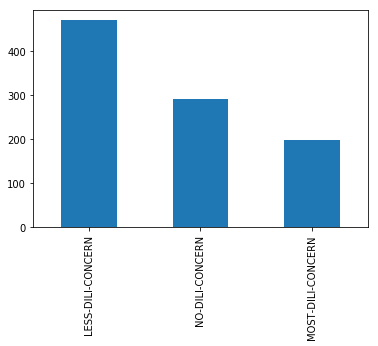

In [9]:
# examine the DILIConcern data
plt.figure();
df['DILIConcern'].value_counts().plot(kind='bar')

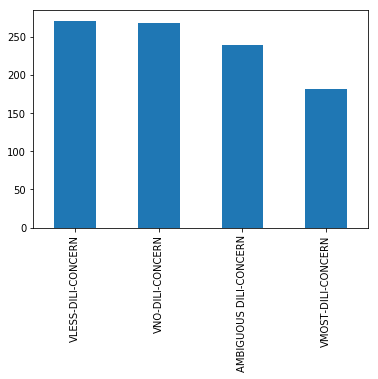

In [10]:
# examine the vDILIConcern data
plt.figure();
df['vDILIConcern'].value_counts().plot(kind='bar')

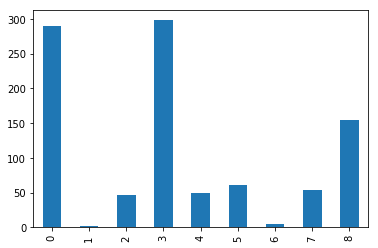

In [11]:
# examine the SeverityClass data
plt.figure();
df['SeverityClass'].value_counts(sort=False).plot(kind='bar')

If you inspect these molecules they are pretty nasty. They have multiple fragments, and some of them are huge. Some are inorganic sales, others organometallics.
We need to clean this up, so start by standardizing the molecucles on the assumption that there is a 'drug' component that is the active component, plus 'salts' that are largely irrelevant. This is an approach typical to a compound registration system. This converts them into a "standard" representation, selects the biggest fragment (e.g. removes counter ions and solvents) and neutralises the molecule.

It turns out that this is useful, but far from perfect for this unusual dataset.

In [12]:
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger

# First add the full molecule, prior to standardization
df['FULL_MOL'] = df['SMILES'].apply(lambda smi: Chem.MolFromSmiles(smi))
# and count the number of fragments
df['FRAGS'] =  df['FULL_MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))

# the standarizer currently spits out tons of output on STDOUT so we'll turn logging off for the moment
RDLogger.logger().setLevel(RDLogger.ERROR)

uncharger = rdMolStandardize.Uncharger()

# define the standardize function
def standardize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol = rdMolStandardize.FragmentParent(mol)
        mol = uncharger.uncharge(mol)
    return mol

# apply standardization and add the molecules to the data frame
df['MOL'] = df['SMILES'].apply(standardize)

## and revert logging back to normal
RDLogger.logger().setLevel(RDLogger.INFO)

In [13]:
# create categories
df2 = df.astype({
    'DILIConcern':'category',
    'SeverityClass':'category',
    'LabelSection':'category',
    'AdjudicatedDILI':'category',
    'vDILIConcern':'category',
    'Greene_Annotation':'category',
    'Sakatis_Annotation':'category',
    'Xu_Annotation':'category',
    'Zhu_Annotation':'category',
    'VER_DISP':'category'
    })
df2.dtypes

LTKBID                  object
PubChem_CID            float64
LabelCompoundName       object
ApprovalYear           float64
DILIConcern           category
SeverityClass         category
LabelSection          category
AdjudicatedDILI       category
vDILIConcern          category
Greene_Annotation     category
Sakatis_Annotation    category
Xu_Annotation         category
Zhu_Annotation        category
SMILES                  object
VER_DISP              category
FULL_MOL                object
FRAGS                    int64
MOL                     object
dtype: object

In [14]:
# these functions will be used to reshape the dataframe so that the original and standardized forms of
# the molecucles can be compared. Pass in the original dataframe to the reshapeDataframe method and
# you get back a dataframe with 2 columns (LABEL and MOL) that contains pairs of rows, the fist containing 
# the LTKBID and FULL_MOL and the second the LabelCompoundName and the standardized MOL.
#
# When you display these molecules in a 2 column grid you will see the original mol on the left and the 
# standardized mol on the right, adn you can see the LTKBID and compound names.

def reshapeRow(df, fullmol, mol, ltkbid, name):
    df.loc[len(df)] = [ltkbid, fullmol]
    df.loc[len(df)] = [name, mol]

def reshapeDataframe(df):
    reshaped = pd.DataFrame(columns=['NAME', 'MOL'])
    df.apply(lambda row: reshapeRow(reshaped, row['FULL_MOL'], row['MOL'], row['LTKBID'], row['LabelCompoundName']), axis=1)
    return reshaped

Let's see how the standarization has worked. We'll reshape the data using the functions in the previous cell and 
then display the orginal and standardized molecules side by side. 
We'll use only the multi-fragment molecules as these are the ones most affected by standardization.  

In [15]:
multiFragMols = df[df['FRAGS'] > 1]
compareMolsDF = reshapeDataframe(multiFragMols)
compareMolsDF.shape

(118, 2)

/opt/conda/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


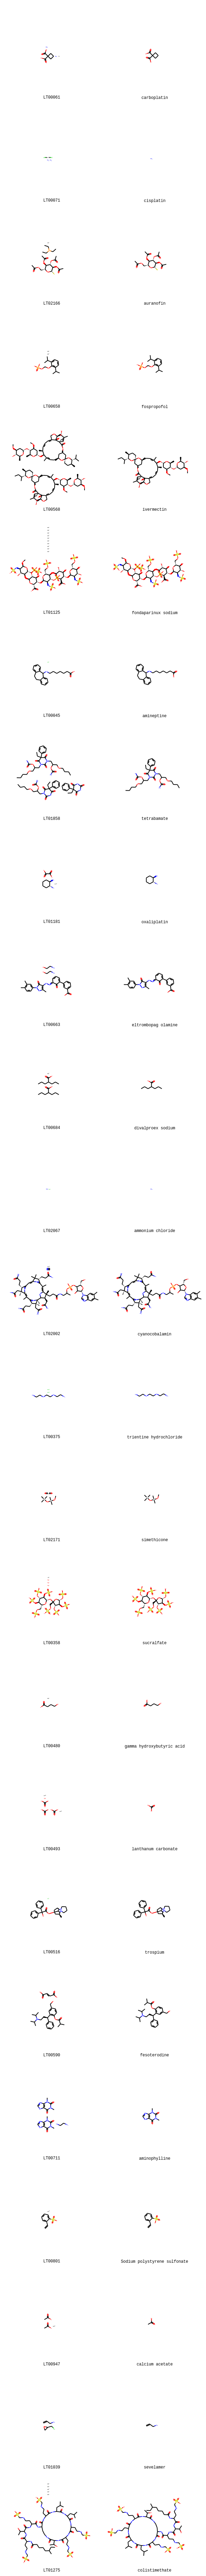

In [16]:
 PandasTools.FrameToGridImage(compareMolsDF, column='MOL', legendsCol='NAME', molsPerRow=2, subImgSize=(300, 300))

We see that mostly the standarization has worked OK but there are a considerable number of strange cases.
We need examine this more carefully. This is a nasty dataset!

Let's inspect the data now. We have a wide range of types of molecules here and it will be best to focus on the main corpus of data and exclude the very quirky molecules as they will not be useful for predictions. 
We'll take a 'drug-discovery' perspective to this, so let's start by examining the size of the molecules (as indicated by the heavy atom count) and the cLogP. Also let's count the number of fragments to check that they all have just one now.

In [17]:
# calculate LogP, heavy atom count and number of fragments
from rdkit.Chem import Descriptors
df2['LOGP'] = df2['MOL'].apply(lambda mol: Descriptors.MolLogP(mol))
df2['HAC'] = df2['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))

<Figure size 432x288 with 0 Axes>

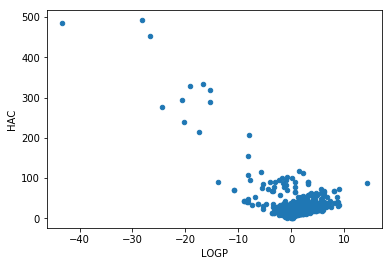

In [18]:
plt.figure();
df2.plot.scatter(x='LOGP', y='HAC');

So we have a small number of very large molecules and a small number of molecules with very low cLogP values. Mostly these are the same molecules. Let's look at them.
Playing around with the filters a bit we conclude that we should exclude mols with a LogP < 14 and HAC > 200.

In [19]:
nastyMols = df2[df2['LOGP'] < -14]
nastyMols = nastyMols[nastyMols['HAC'] > 200]
nastyMols.shape

(11, 20)

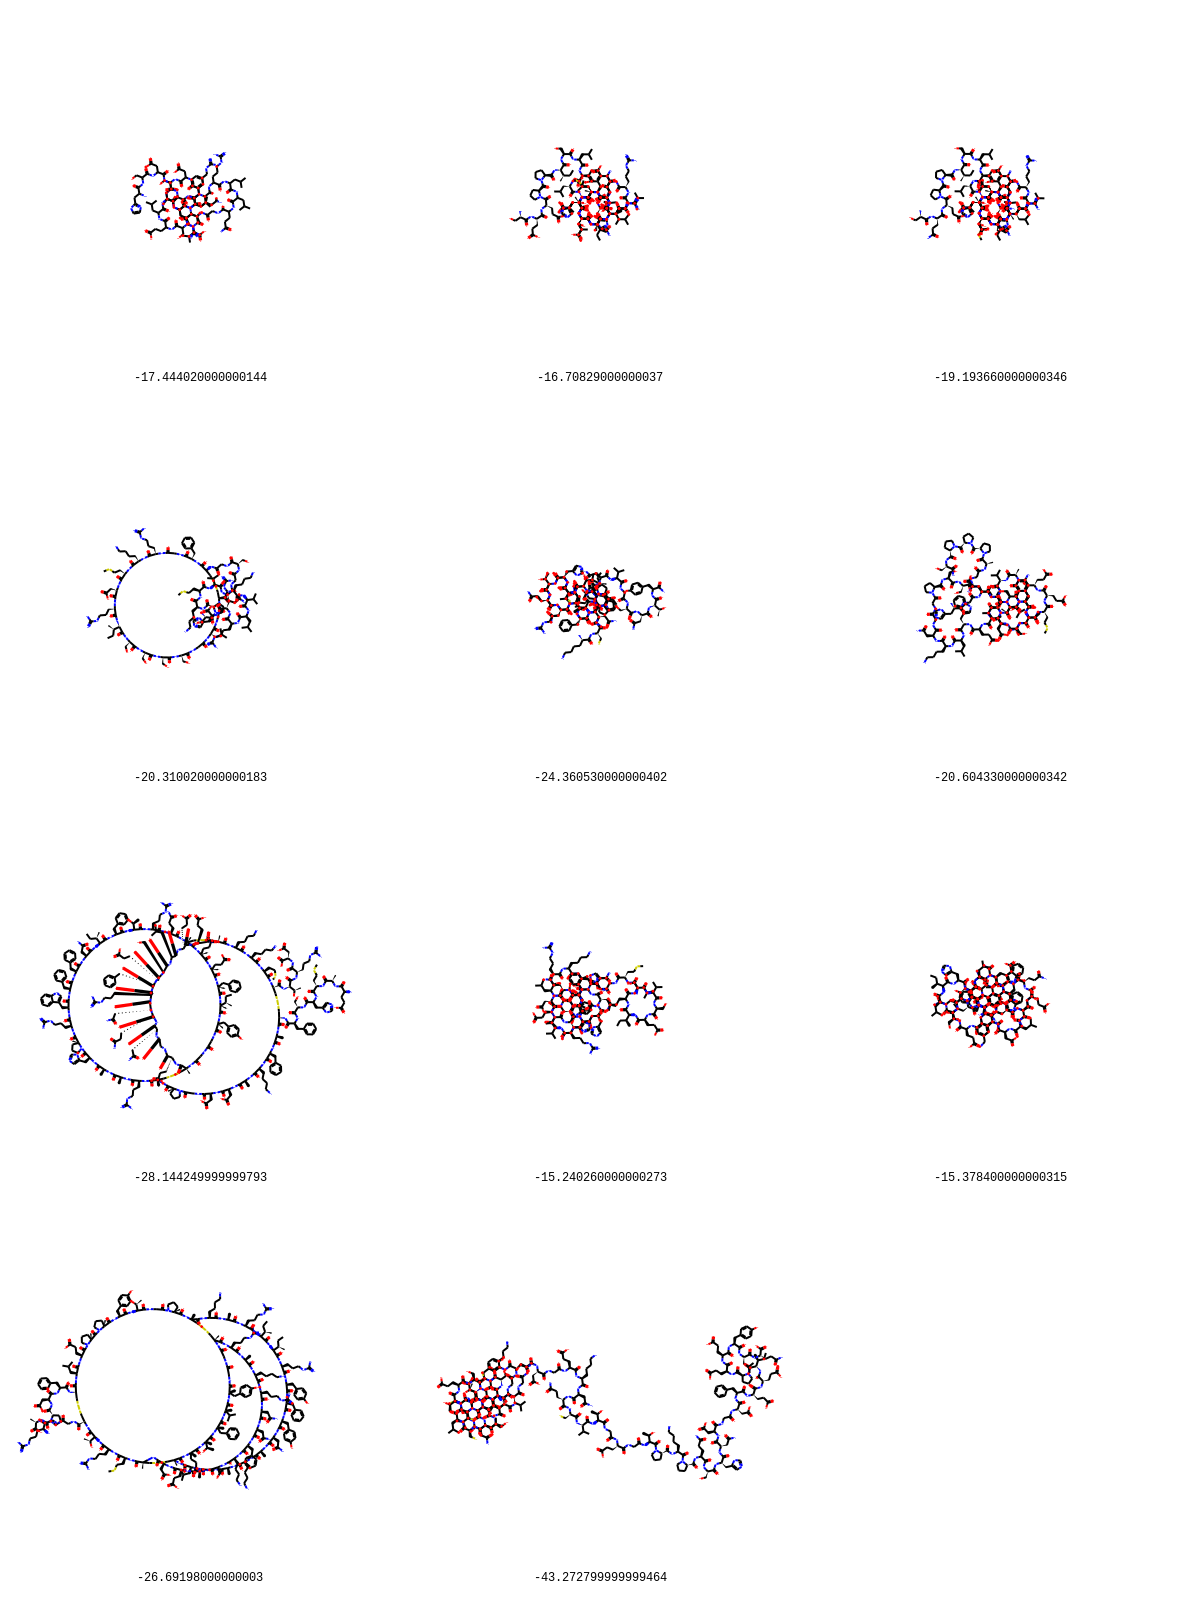

In [ ]:
PandasTools.FrameToGridImage(nastyMols, column='MOL', legendsCol='LOGP', molsPerRow=3, subImgSize=(400, 400))

So we see some horrible molecules - lot's of macrocycles and heavily conjugated systems.
Whilst chemical fingerprint techniques should work OK wiht these, they appear to be outliers so will not be that useful for machine learning.

So let's exclude those monsters and get only the nice mols. We might want to treat these as a special case or investigate further as additional work.

In [ ]:
niceMols = df2[df2['LOGP'] >= -14]
niceMols = niceMols[niceMols['HAC'] <= 200]
niceMols.shape

(948, 20)

We've lost a further 12 molecules.
Let's look at the ones that remain.
They look drug like!

In [ ]:
PandasTools.FrameToGridImage(niceMols, column='FULL_MOL', legendsCol='LTKBID', molsPerRow=4, subImgSize=(400, 400))

And their 'drug-likeness' distribution:

In [ ]:
plt.figure();
niceMols.plot.scatter(x='LOGP', y='HAC');

Now generate Morgan2 and RDKit fingerprints that we can use for machine learning.
This is just for illustrative purposes - we don't use them in this notebook.

In [ ]:
niceMols['RDK5'] = niceMols.MOL.apply(lambda mol: Chem.RDKFingerprint(mol, maxPath=5))
niceMols['MORGAN2'] = niceMols.MOL.apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))

In [ ]:
# get an iddea of what the fingerprints looks like
niceMols['RDK5']

In [ ]:
# look at the Most DILI mols
mostDili = niceMols[niceMols['DILIConcern'] == 'MOST-DILI-CONCERN']
mostDili.shape

These are the Most DILI molecules from our cleaned set.

In [ ]:
PandasTools.FrameToGridImage(mostDili, column='FULL_MOL', legendsCol='LTKBID', molsPerRow=4, subImgSize=(300, 300))

# Cleaning very small molecules
Very small molecules are also problematical as:

1. the standardization process may not be correct for these
1. the SMILES representation of organometallics is deficient (unable to descrive coordinate bonds), resulting in incorrect molecular representations
1. very few bits will be set in the fingerprints

Let's try to take a look at these.

In [ ]:
df['THAC'] = df['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))
smallMols = df[df['THAC'] < 10]
smallMols.shape

Let's look as these small molecules

In [ ]:
reshaped = reshapeDataframe(smallMols)
reshaped.shape

In [ ]:
PandasTools.FrameToGridImage(reshaped, column='MOL', legendsCol='NAME', molsPerRow=2, subImgSize=(300, 300))

This confirms that the curation is not perfect. Look at:
* cisplatin (LT00071)
* ferumoxytol (LT00650)
* nitroprusside (LT00880)
* gallium nitrate (LT02064)
* lanthanum carbonate (LT00493)

Mostly this applies to organometallic compounds such as cisplatin which cannot even be correctly defined using SMILES (coodination bonds etc.) and the molecular fingerprints that are generated from these will be pretty meaningless. __Probably all organometallics should be excluded from the dataset__ or should be handled seprately with a different approach, but there probably aren't enough of these to generate any meaninful predictive power anyway.

We'll create a black list that contains the cherry picked rows that we want to exclude.

In [ ]:
# This list may not be exhaustive.

blackList = [
    'LT00071', # cisplatin - organometallic
    'LT01181', # oxaplatin - organometallic
    'LT00061', # carboplatin - organometallic
    'LT01181', # oxaliplatin - organometallic
    'LT02067', # ammonium chcloride - trivial inorganic salt
    'LT00493', # lanthanum carbonate - trivial inorganic salt
    'LT00947', # calcium acetate - trivial inorganic salt
    'LT00330', # sodium lactate - radioisotope
    'LT00361', # cupric chloride - trivial inorganic salt
    'LT00349', # sodium thiosulfate - trivial inorganic salt
    'LT00650', # ferumoxytol - organometallic
    'LT02337', # sodium bicarbonate - trivial inorganic salt
    'LT00880', # nitroprusside - organometallic
    'LT02064', # gallium nitrate - organometallic
    'LT02166', # auranofin - contains gold,
    'LT00528', # gadofosveset trisodium - contains gadolinium
    'LT00935', # gadopentetate dimeglumine - contains gadolinium
    'LT00952', # gadoteridol - contains gadolinium
    'LT01044', # gadoversetamide - contains gadolinium
]

In [ ]:
# This lets's us look at an individual molecule given it's LTKBID
# You can edit the ID to see any molecule you want.
s = df2[df2['LTKBID'] == 'LT00061']['SMILES']
Chem.MolFromSmiles(s.values[0])

Molecules with metal atoms seem to be a particular problem, so lets find all molecules that contain 'large' atoms.
By large we'll use an atomic number of 17 (Chlorine), though we need to consider each case individually as that will include Bromine, Iodine and other atoms that we won't want to exclude 

In [ ]:
# find the biggest atom in a molecule
def biggestAtom(mol):
    biggest = 0
    counter = 0
    for atom in mol.GetAtoms():
        an = atom.GetAtomicNum()
        if an > biggest:
            biggest = an
    return an
        
df2['MAX_ATOMIC_NUMBER'] = df2['FULL_MOL'].apply(lambda mol: biggestAtom(mol))
biggies = df2[df2['MAX_ATOMIC_NUMBER'] > 17] # atomic number 17 is chlorine

# reshape
reshapedBiggies = reshapeDataframe(biggies)
PandasTools.FrameToGridImage(reshapedBiggies, column='MOL', legendsCol='NAME', molsPerRow=2, subImgSize=(300, 300))

In [ ]:
# remove the baddies from the niceMols
# this is currently out best attempt for a dataset suitable for machine learning using the RDKit fingerprints.

nonBlackListedNiceMols = niceMols[~niceMols['LTKBID'].isin(blackList)]
nonBlackListedNiceMols.shape

In [ ]:
nonBlackListedNiceMols['STD_SMILES'] = nonBlackListedNiceMols['MOL'].apply(lambda m: Chem.MolToSmiles(m))
nonBlackListedNiceMols.dtypes

In [ ]:
nonBlackListedNiceMols[['LTKBID','LabelCompoundName','DILIConcern','SMILES','STD_SMILES']].head()

In [ ]:
# write out the dataset as CSV
nonBlackListedNiceMols.to_csv('cleaned-2019-2-18.csv', index=False,
                              columns=['LTKBID','PubChem_CID','LabelCompoundName','DILIConcern',
                                       'SeverityClass','AdjudicatedDILI','vDILIConcern','Greene_Annotation',
                                       'Sakatis_Annotation','Xu_Annotation','Zhu_Annotation',
                                       'SMILES','STD_SMILES'])